In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head(5)

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B


# 1. 결측치 제거

## 주택소유상태

In [4]:
df = df.drop(index=df[df['주택소유상태'] == 'ANY'].index)


## ID
미리 ID 제거

### 이상치

In [5]:
numeric_col = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액', '연체계좌수', '근로기간']
category_col = ['대출기간', '주택소유상태', '대출목적']


In [6]:
import numpy as np

numeric_cols = ['연간소득', '총계좌수', '최근_2년간_연체_횟수', '총상환원금', '총상환이자', '총연체금액','부채_대비_소득_비율']

# 표준편차 사용하여 이상치 제거
def remove_outliers(df, col, threshold=3):
    mean = np.mean(df[col])
    std_dev = np.std(df[col])
    lower_bound = mean - threshold * std_dev
    upper_bound = mean + threshold * std_dev
    df= df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

# 이상치 제거 후 데이터프레임 생성
df = df.copy()  # 복사본 생성

for col in numeric_cols:
    df = remove_outliers(df, col, threshold=3)

# 이상치 제거 후 데이터프레임 크기 확인
print("이상치 제거 후 데이터프레임 크기:")
print(df)

이상치 제거 후 데이터프레임 크기:
                ID      대출금액        대출기간       근로기간    주택소유상태       연간소득  \
0      TRAIN_00000  12480000   36 months    6 years      RENT   72000000   
1      TRAIN_00001  14400000   60 months  10+ years  MORTGAGE  130800000   
2      TRAIN_00002  12000000   36 months    5 years  MORTGAGE   96000000   
3      TRAIN_00003  14400000   36 months    8 years  MORTGAGE  132000000   
4      TRAIN_00004  18000000   60 months    Unknown      RENT   71736000   
...            ...       ...         ...        ...       ...        ...   
96289  TRAIN_96289  14400000   36 months  10+ years  MORTGAGE  210000000   
96290  TRAIN_96290  28800000   60 months  10+ years  MORTGAGE  132000000   
96291  TRAIN_96291  14400000   36 months     1 year  MORTGAGE   84000000   
96292  TRAIN_96292  15600000   36 months    5 years  MORTGAGE   66330000   
96293  TRAIN_96293   8640000   36 months  10+ years      RENT   50400000   

       부채_대비_소득_비율  총계좌수   대출목적  최근_2년간_연체_횟수    총상환원금     총상환이자  총

# 회귀모델

In [7]:
def year_encoder(x):
    output = x.replace('years', '')
    output = output.replace('year', '')
    output = output.replace('+', '')
    output = output.replace('<', '')
    output = output.replace('Unknown', '-1').strip()
    output = int(output)

    return output

In [8]:
df['근로기간'] = df['근로기간'].apply(year_encoder)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

df_known = df[df['근로기간'] != -1]

X_train = df_known[['연간소득']]
y_train = df_known['근로기간']

regressor = LinearRegression()
regressor.fit(X_train, y_train)

X_pred = df[df['근로기간'] == -1][['연간소득']]
predicted_years = regressor.predict(X_pred)

df.loc[df['근로기간'] == -1, '근로기간'] = predicted_years

print(df)

                ID      대출금액        대출기간       근로기간    주택소유상태       연간소득  \
0      TRAIN_00000  12480000   36 months   6.000000      RENT   72000000   
1      TRAIN_00001  14400000   60 months  10.000000  MORTGAGE  130800000   
2      TRAIN_00002  12000000   36 months   5.000000  MORTGAGE   96000000   
3      TRAIN_00003  14400000   36 months   8.000000  MORTGAGE  132000000   
4      TRAIN_00004  18000000   60 months   5.946278      RENT   71736000   
...            ...       ...         ...        ...       ...        ...   
96289  TRAIN_96289  14400000   36 months  10.000000  MORTGAGE  210000000   
96290  TRAIN_96290  28800000   60 months  10.000000  MORTGAGE  132000000   
96291  TRAIN_96291  14400000   36 months   1.000000  MORTGAGE   84000000   
96292  TRAIN_96292  15600000   36 months   5.000000  MORTGAGE   66330000   
96293  TRAIN_96293   8640000   36 months  10.000000      RENT   50400000   

       부채_대비_소득_비율  총계좌수   대출목적  최근_2년간_연체_횟수    총상환원금     총상환이자  총연체금액  \
0           

# 스케일링

In [12]:
from sklearn.model_selection import train_test_split

X = df.drop(['ID', '대출등급'], axis=1)
y = df[['대출등급']]

print(X.shape, y.shape)

(90618, 13) (90618, 1)


In [13]:
def numeric_scaler(X):
    
    sc_col = ['최근_2년간_연체_횟수', '총연체금액', '연체계좌수']
    mm_col = ['대출금액', '연간소득', '부채_대비_소득_비율', '총계좌수', '총상환원금', '총상환이자', '근로기간']
    
    from sklearn.preprocessing import StandardScaler, MinMaxScaler
    
    sc = StandardScaler()
    mm = MinMaxScaler()
    
    X[sc_col] = sc.fit_transform(X[sc_col])
    X[mm_col] = mm.fit_transform(X[mm_col])
    
    return X

X = numeric_scaler(X)

# 인코딩

In [14]:
category_col = ['대출기간', '주택소유상태','대출목적']

In [15]:
def category_encoder(X:pd.DataFrame):
     X_dummies = pd.get_dummies(X[category_col])
     
     X = pd.concat([X, X_dummies], axis=1)
     
     return X, X_dummies.columns.to_list()

X, dummies_col = category_encoder(X)

In [16]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y['대출등급'])


y['대출등급'] = le.transform(y['대출등급'])

In [18]:
## 예시

for col in category_col:
    print(col)
    display(df[df['대출등급'] == "A"][col].value_counts() / df[df['대출등급'] == "A"][col].value_counts().sum())
    print('----------------------------------')


대출기간


 36 months    0.950595
 60 months    0.049405
Name: 대출기간, dtype: float64

----------------------------------
주택소유상태


MORTGAGE    0.572403
RENT        0.316948
OWN         0.110650
Name: 주택소유상태, dtype: float64

----------------------------------
대출목적


부채 통합     0.479172
신용 카드     0.384081
주택 개선     0.072279
주요 구매     0.022006
기타        0.021076
자동차       0.010166
의료        0.006323
휴가        0.002480
소규모 사업    0.001116
이사        0.000744
주택        0.000496
재생 에너지    0.000062
Name: 대출목적, dtype: float64

----------------------------------


In [19]:
X = df.drop(['ID', '대출등급'], axis=1)
y = df[['대출등급']]

In [20]:
y.value_counts()

대출등급
B       27674
C       26357
A       16132
D       12287
E        6389
F        1493
G         286
dtype: int64

In [21]:
X, dummies_col = category_encoder(X)
X = X.drop(columns=category_col)

In [22]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y['대출등급'])


y['대출등급'] = le.transform(y['대출등급'])

In [23]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

X, y = sm.fit_resample(X, y)

In [24]:
y.value_counts()

대출등급
0       27674
1       27674
2       27674
3       27674
4       27674
5       27674
6       27674
dtype: int64

# 파생변수

In [25]:
X['dv_category'] = ((2 * X['대출기간_ 36 months']) + X['주택소유상태_MORTGAGE'] + X['대출목적_부채 통합']) / 4  # 대출 등급별 category_col 분포 특성을 반영
X['dv_ratio'] = (X['총상환원금'] / X['대출금액']) * 100                                                     # 대출금액 대비 총상환원금(0인 값 처리를 위해 +1)
X['dv_short_ability'] = (X['연간소득'] / 12) - (X['대출금액'] / 36)                                           # 단기상환능력                                   
X['dv_left_debt'] = X['대출금액'] - X['총상환원금'] - X['총상환이자']                                          # 잔여대출금
X['dv_rent_p'] = (X['총상환원금'] / X['대출금액']) * 100                                                      # 대출 금액 대비 총상환금 비율
X['dv_rent_i'] = (X['총상환이자'] / X['대출금액']) * 100


In [26]:
dummies_col = dummies_col + ['dv_category']
numeric_col = numeric_col + ['dv_ratio', 'dv_short_ability', 'dv_left_debt', 'dv_rent_p', 'dv_rent_i']

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42, shuffle=True)

In [28]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(154974, 33) (38744, 33) (154974, 1) (38744, 1)


In [29]:
dummies_col

['대출기간_ 36 months',
 '대출기간_ 60 months',
 '주택소유상태_MORTGAGE',
 '주택소유상태_OWN',
 '주택소유상태_RENT',
 '대출목적_기타',
 '대출목적_부채 통합',
 '대출목적_소규모 사업',
 '대출목적_신용 카드',
 '대출목적_의료',
 '대출목적_이사',
 '대출목적_자동차',
 '대출목적_재생 에너지',
 '대출목적_주요 구매',
 '대출목적_주택',
 '대출목적_주택 개선',
 '대출목적_휴가',
 'dv_category']

# 모델링

In [48]:
def get_score(train:pd.DataFrame,  test:pd.DataFrame, x_var_list:list):
    
    X_train = train 
    X_test = test

    X_train = X_train[x_var_list]
    X_test = X_test[x_var_list]
    
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
    from xgboost import XGBClassifier
    from lightgbm import LGBMClassifier
    from sklearn.metrics import f1_score, accuracy_score
    
    logit = LogisticRegression()
    decision = DecisionTreeClassifier(random_state=42)
    rfc = RandomForestClassifier(random_state=42)
    gbc = GradientBoostingClassifier(random_state=42)
    xgb = XGBClassifier(random_state=42)
    light = LGBMClassifier(random_state=42)
    
    logit.fit(X_train, y_train)
    decision.fit(X_train, y_train)
    rfc.fit(X_train, y_train)
    gbc.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    light.fit(X_train, y_train)
    
    y_pred_train = logit.predict(X_train)
    y_pred_test = logit.predict(X_test)
    
    result_logit = pd.DataFrame({'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_test)],
                            'f1_score' : [f1_score(y_train, y_pred_train, average='macro'), f1_score(y_val, y_pred_test, average='macro')]},
                            index = ['train','test'])
    
    y_pred_train = decision.predict(X_train)
    y_pred_test = decision.predict(X_test)
    
    result_decision = pd.DataFrame({'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_test)],
                            'f1_score' : [f1_score(y_train, y_pred_train, average='macro'), f1_score(y_val, y_pred_test, average='macro')]},
                            index = ['train','test'])
    
    y_pred_train = rfc.predict(X_train)
    y_pred_test = rfc.predict(X_test)
    
    result_rfc = pd.DataFrame({'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_test)],
                            'f1_score' : [f1_score(y_train, y_pred_train, average='macro'), f1_score(y_val, y_pred_test, average='macro')]},
                            index = ['train','test'])
    
    y_pred_train = gbc.predict(X_train)
    y_pred_test = gbc.predict(X_test)
    
    result_gbc = pd.DataFrame({'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_test)],
                            'f1_score' : [f1_score(y_train, y_pred_train, average='macro'), f1_score(y_val, y_pred_test, average='macro')]},
                            index = ['train','test'])
    
    y_pred_train = xgb.predict(X_train)
    y_pred_test = xgb.predict(X_test)
    
    result_xgb = pd.DataFrame({'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_test)],
                            'f1_score' : [f1_score(y_train, y_pred_train, average='macro'), f1_score(y_val, y_pred_test, average='macro')]},
                            index = ['train','test'])
    
    y_pred_train = light.predict(X_train)
    y_pred_test = light.predict(X_test)
    
    result_light = pd.DataFrame({'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_test)],
                            'f1_score' : [f1_score(y_train, y_pred_train, average='macro'), f1_score(y_val, y_pred_test, average='macro')]},
                            index = ['train','test'])
    
    print('로지스틱')
    display(result_logit.round(2))
    print()
    print('의사결정나무')
    display(result_decision.round(2))
    print()
    print('랜덤포레스트')
    display(result_rfc.round(2))
    print()
    print('그라디언트 부스팅')
    display(result_gbc.round(2))
    print()
    print('XG 부스팅')
    display(result_xgb.round(2))
    print()
    print('Light GBM')
    display(result_light.round(2))
    

In [ ]:
print(X_train.columns)
print(X_val.columns)

In [30]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score



xgb = XGBClassifier(random_state=42)
xgb.fit(X_train[dummies_col + numeric_col], y_train)
    
y_pred_train = xgb.predict(X_train[dummies_col + numeric_col])
y_pred_val = xgb.predict(X_val[dummies_col + numeric_col])
    
result_xgb = pd.DataFrame(data={'acc' : [accuracy_score(y_train, y_pred_train), accuracy_score(y_val, y_pred_val)],
                                'f1_score' : [f1_score(y_train, y_pred_train, average='macro'), f1_score(y_val, y_pred_val, average='macro')]},
                          index=['train','test'])
    
display(result_xgb.round(2))

,acc,f1_score
train,0.96,0.96
test,0.94,0.94


In [31]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(y_val, y_pred_val)
confusion

array([[5354,  140,   27,   10,    1,    0,    2],
       [ 127, 5266,  131,    6,    5,    0,    0],
       [  39,  167, 5195,  103,   29,    1,    1],
       [  34,   41,  132, 4882,  383,   46,   17],
       [   6,   10,   56,  384, 4882,  172,   25],
       [   1,    3,   18,   33,  143, 5237,  100],
       [   0,    0,    0,    1,    6,   40, 5488]], dtype=int64)

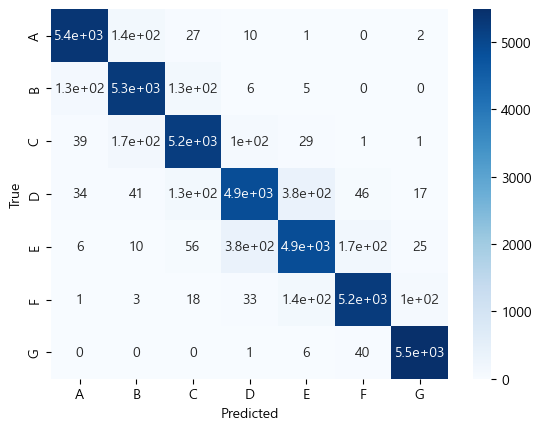

In [32]:
labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

sns.heatmap(confusion, cmap='Blues',annot=True ,xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [37]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    xgb = XGBClassifier(random_state=42)
    xgb.fit(X_train, y_train)
    y_pred = xgb.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f'Accuracy: {accuracy}')

Accuracy: 0.939242205244683
Accuracy: 0.9378226306008672
Accuracy: 0.9374096634317571
Accuracy: 0.9360916810778721
Accuracy: 0.9356787032496193


In [38]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

xgb = XGBClassifier(random_state=42)

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

Best parameters found:  {'learning_rate': 0.3, 'max_depth': 7, 'n_estimators': 300}
Best accuracy found:  0.9457009195031457


In [39]:
best_n_estimators = grid_search.best_params_['n_estimators']
best_max_depth = grid_search.best_params_['max_depth']
best_learning_rate = grid_search.best_params_['learning_rate']

best_xgb_model = XGBClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, learning_rate=best_learning_rate)

best_xgb_model.fit(X_train, y_train)

y_pred = best_xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Final Accuracy:", accuracy)

Final Accuracy: 0.9523526830653279


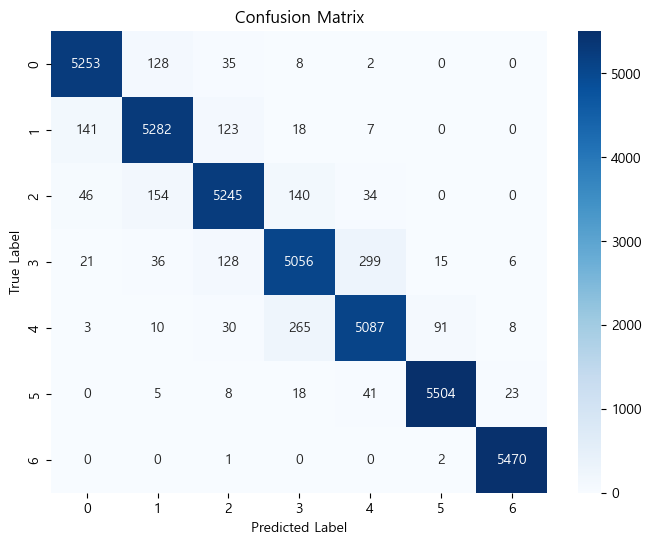

In [49]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G']

conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

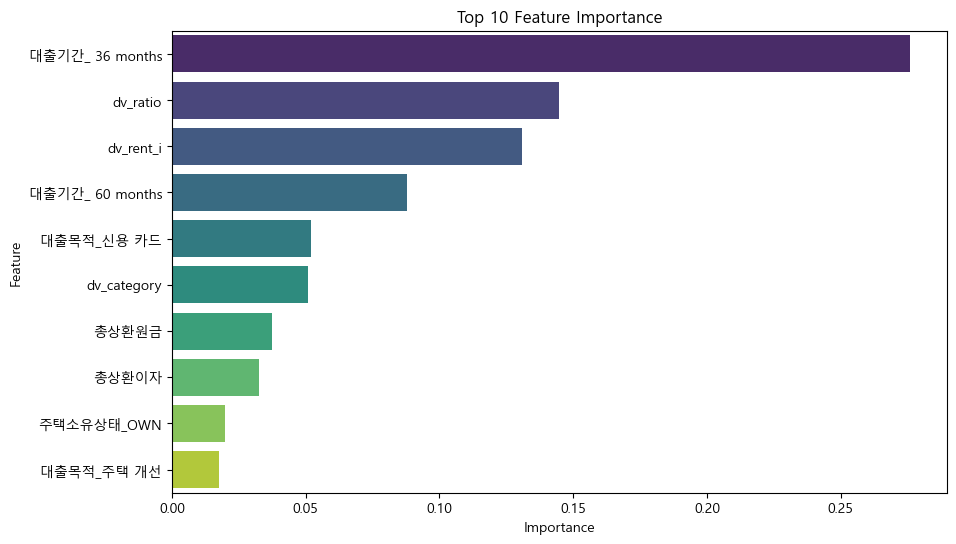

In [46]:
best_xgb_model.fit(X_train, y_train)

importances = best_xgb_model.feature_importances_

feature_names = X_train.columns

importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(top_n), palette='viridis')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title(f'Top Feature Importance')
plt.show()